In [ ]:
import numpy as np

def coalition_opportunities(F, top_targets = None, strict = True):
    """
    Compute coalition opportunity counts by rank.

    Parameters:

    F : 1D-array of Fighting Abilities, sorted so F[0] is the strongest (rank 1).
        F[1] is rank 2, ... F[N-1] is rank N (weakest member)
        **Unlke in R, Python uses 0-indexing so the very first value in the array(equivalent of a vector in R) is indexed at F[0]
            rather than F[1]. The last value or object in the Array F is F[N - 1], rather than F[N].

    top_targets : int or none
        If None: any higher-ranking male can be a target
        If int I: only ranks 1...I are considered possible targets.
        **This is supposed to allow for the additional condition
            shown in Noe(1994) figure 3 where the targets are limited to a certain number of top males (top 3 for example)**


    strict : boolean
        If True, coalition must strictly beat target: F_i + F_j > F_k
        if False, allow F_i + F_j >= F_K (additional assumption I added since Noe asssumes F_i + F_j > F_k)
        **This allows us to play around with the Strength Condition derived from assumption 5 and 6 a bit**


    Returns:

    counts : np.ndarray
        Array of length N with coalition opportunity counts for each male (rank), this is ultimatley what is visualized at the end.

    """

    #1. Initialize counters and other essential data structures for the model

    F = np.asarray(F, dtype = float) #create an array of fighting abilities
    N = len(F) #the number of males in the group, N, is set equal to the length of our fighting ability array, F
    counts = np.zeros(N, dtype = int) # create an array of 0s that is the same size as N

    #2. Loop that calculates fighting abilities of each pair and sees which target males can be beaten
    for i in range(N): #for each male, i, in N
        for j in range(i + 1, N): #for every other male, j, in N with a higher integer value (i.e. lower/less dominant) rank
            Fij = F[i] + F[j] #calculate the fighting ability of that pairing

            if top_targets is None: #No restrictions on target males, equivalent to Noe's original model interpretation
                k_max = i #Sets maximum number of targets for i and any other j, since Fi always > Fj
            else: # for special case with limiting target males to a certain # of the top males
                k_max = min(i, top_targets) #sets the pool of feasible target males to i's rank or the number in top_targets, whichever is smaller
            if k_max <= 0: #if there are no potential targets for this male i, iterate the loop to the next male i (i + 1 i guess)
                continue

            for k in range(k_max): #if there were target males, we do calculations to see which target males, k, can be beaten by {i,j}
                if strict:
                    coalitionsFormed = Fij > F[k]
                else:
                    coalitionsFormed = Fij >= F[k]


                if coalitionsFormed:
                    counts[i] += 1
                    counts[j] += 1

    return counts
    # once the loop has passed over every potential value of j for each i and calculated the targets, k, which can be beaten, we add those
    # to our count array for each coalition member.

# The following three functions capture the three fighting ability curves used in Noe(1994).
# These are used to set the values for the array F, which is how we will generate the distributions from the original Noe model.

def curve_shallow(N, max_strength = 100.0, min_strength = 50.0):
    """ Shallow Decline, top vs bottom ranks difference in fighting ability = ~2:1"""

    ranks = np.arange(N)
    return max_strength - (max_strength - min_strength) * (ranks / (N - 1))

def curve_intermediate(N, max_strength = 100.0, min_strength = 25.0):
    """ For this curve, the difference between the top and bottom rank is ~4:1"""

    ranks = np.arange(N)
    return max_strength - (max_strength - min_strength) * (ranks / (N-1))

def curve_steep(N, max_strength = 100.0, min_strength = 10.0):
    """For the steep curve, the top rank individual is 10x stronger than the lowest, ~10:1"""

    ranks = np.arange(N)
    return max_strength - (max_strength - min_strength) * (ranks / (N - 1))

# I realized that this approach makes all of the fighting ability decay functions perfectly linear, however Noe uses a slight sigmoidal curve for each
# of his fighting ability curves, so I will re-write these functions to capture the s-shaped structure Noe used to capture the biology of ageing

# Sigmoid function is:
#
# S(x) = (1)/(1 + e^-kx)
#
# where k allows us to control the steepness of the middle section of the curve

def curve_sigmoid(N, max_strength=100, min_strength=25.0, steepness=1.0):
    ranks = np.arange(N) #creates an array of ranks (1,2,3,4,...N)
    x = (ranks - (N/2)) / (N/8) # centers the sigmoid and scales width
    logistic = 1 / (1 + np.exp(steepness * x))
    # Scale to desired min/max
    return min_strength + (max_strength - min_strength) * logistic



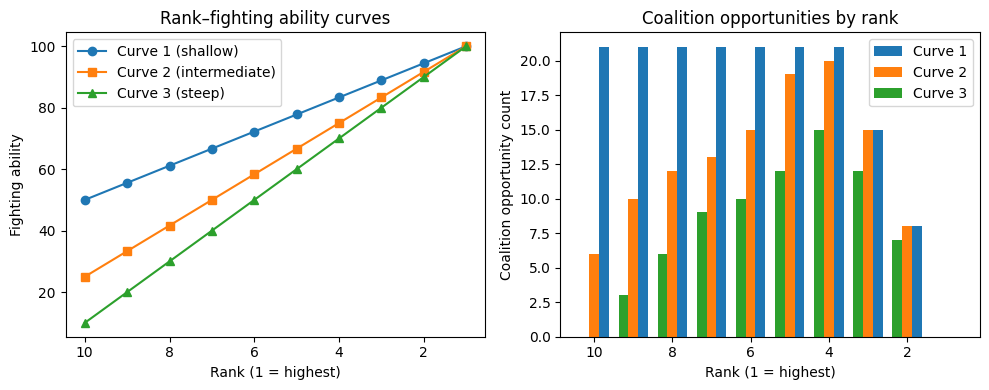

In [ ]:
import matplotlib.pyplot as plt

def make_model_visuals(N=10):
    # 1. Fighting ability curves
    F1 = curve_shallow(N)
    F2 = curve_intermediate(N)
    F3 = curve_steep(N)


    ranks = np.arange(1, N + 1)

    # 2. Coalition opportunity counts
    C1 = coalition_opportunities(F1, top_targets = 3, strict = True)
    C2 = coalition_opportunities(F2, top_targets = 3, strict = True)
    C3 = coalition_opportunities(F3, top_targets = 3, strict = True)

    # I used top_target = 3 here because this is the what Noe did to get the closest distribution to what is observed in the natural system in figure 3.
    # When looking at the 3 curve's distributions below, notice that curve 2 (the most similar to the distribution of FA we see in the natural system), is the most representative of the real
    # distribution, where middle ranked males get the most coalitionary opportunities

    # 3. Plot fighting ability curves
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(ranks, F1, marker="o", label="Curve 1 (shallow)")
    plt.plot(ranks, F2, marker="s", label="Curve 2 (intermediate)")
    plt.plot(ranks, F3, marker="^", label="Curve 3 (steep)")
    plt.gca().invert_xaxis()
    plt.xlabel("Rank (1 = highest)")
    plt.ylabel("Fighting ability")
    plt.title("Rank–fighting ability curves")
    plt.legend()

    # 4. Plot coalition opportunity distributions
    width = 0.25
    plt.subplot(1, 2, 2)
    plt.bar(ranks - width, C1, width=width, label="Curve 1")
    plt.bar(ranks, C2, width=width, label="Curve 2")
    plt.bar(ranks + width, C3, width=width, label="Curve 3")
    plt.gca().invert_xaxis()
    plt.xlabel("Rank (1 = highest)")
    plt.ylabel("Coalition opportunity count")
    plt.title("Coalition opportunities by rank")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    make_model_visuals()

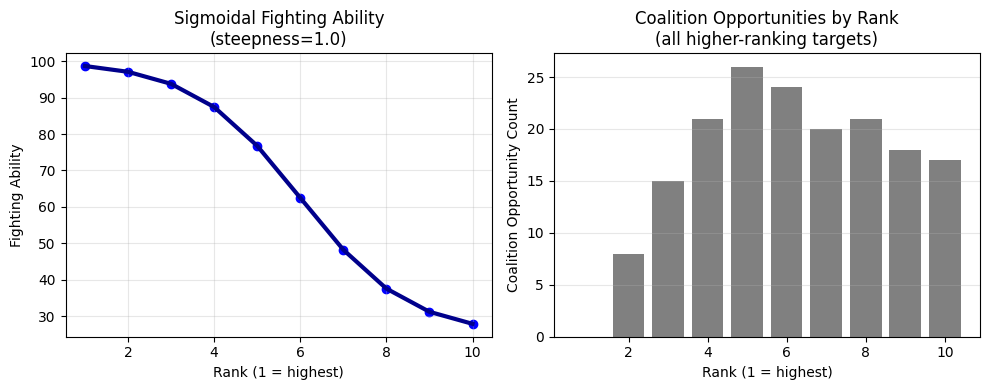

In [ ]:
def plot_sigmoid_visual(N=10,
                                max_strength=100,
                                min_strength=25.0,
                                steepness=1.0,
                                top_targets=None,
                                show_points=True):

    # 1. Fighting ability curve from sigmoid function
    F = curve_sigmoid(N, max_strength=max_strength,
                      min_strength=min_strength,
                      steepness=steepness)
    ranks = np.arange(1, N + 1)

    # 2. Coalition opportunities by rank
    C = coalition_opportunities(F, top_targets=top_targets)

    # 3. Set up side-by-side plots
    plt.figure(figsize=(10, 4))

    # plot fighting ability curve using sigmoid function
    plt.subplot(1, 2, 1)
    plt.plot(ranks, F, linewidth=3, color='darkblue', label='Fighting ability')
    if show_points:
        plt.scatter(ranks, F, color='blue')
    title_left = f"Sigmoidal Fighting Ability\n(steepness={steepness})"
    plt.title(title_left)
    plt.xlabel("Rank (1 = highest)")
    plt.ylabel("Fighting Ability")
    plt.grid(True, alpha=0.3)

    # plot of distribution of coalition opportunities across all males
    plt.subplot(1, 2, 2)
    plt.bar(ranks, C, color='grey')
    if top_targets is None:
        title_right = "Coalition Opportunities by Rank\n(all higher-ranking targets)"
    else:
        title_right = f"Coalition Opportunities by Rank\n(only top {top_targets} targets)"
    plt.title(title_right)
    plt.xlabel("Rank (1 = highest)")
    plt.ylabel("Coalition Opportunity Count")
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_sigmoid_visual()
